In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

## Modelling national trust in Germany and other countries over time
This analysis is primarily for the evolution of national trust in germany over time. Other than Germany, we are going to look at Australia, Canada, Great Britan, Netherlands and USA to see how trust has been evolving over time in other developed countries.

Objectives of this analysis
- Build a trust index similar to the `attach_distrust_index` function in `utils.trust_index`
- Rudimentary EDA
- Apply one way ANOVA to the different waves in Germany
  - Oneway ANOVA for omnibus test
  - Another ANOVA applied with linear contrast to check for a linear trend

In [3]:
countries = ['AUS','CAN','GBR','DEU','NLD','USA']
df = pd.read_csv("./data/wvs/WVS_Time_Series.csv").query("COUNTRY_ALPHA in @countries")
df.head()

,version,doi,S001,S002VS,S003,COUNTRY_ALPHA,COW_NUM,COW_ALPHA,S004,S006,S007,S008,MODE,S010,S011A,S011B,S012,S013,S013B,S016,S016B,S017,S018,S020,S021,S022,S023,S024,S025,A001,A002,A003,A004,A005,A006,A008,A009,A010,A011,A012,...,Y002,Y003,Y010,Y011,Y012,Y013,Y014,Y020,Y021,Y022,Y023,Y024,Y011A,Y011B,Y011C,Y012A,Y012B,Y012C,Y013A,Y013B,Y013C,Y014A,Y014B,Y014C,Y021A,Y021B,Y021C,Y022A,Y022B,Y022C,Y023A,Y023B,Y023C,Y024A,Y024B,Y024C,survself,tradrat5,TradAgg,SurvSAgg
15730,5-0-0 (2024-04-30),doi.org/10.14281/18241.25,2,1,36,AUS,900,AUL,-4,1,360120001,-4,6,-4,-4.0,-4.0,-4,-4,-4,-4,-4,0.961614,0.814332,1981,3601211981,198101,198112,361,361981,-4,-4,-4,-4,-4,-4,2,2,-4,-4,-4,...,-4,-2,0.317778,NaN,0.4,0.000000,0.553333,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,0.666667,0.0,0.0,0.0,1.00,0.33,0.33,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15731,5-0-0 (2024-04-30),doi.org/10.14281/18241.25,2,1,36,AUS,900,AUL,-4,2,360120002,-4,6,-4,-4.0,-4.0,-4,-4,-4,-4,-4,0.961614,0.814332,1981,3601211981,198101,198112,361,361981,-4,-4,-4,-4,-4,-4,3,2,-4,-4,-4,...,-4,-1,0.436222,0.2020,NaN,0.666667,0.440000,NaN,0.0,NaN,0.296296,NaN,0.0,0.0,NaN,NaN,1.0,NaN,1.0,1.0,0.0,0.33,0.33,0.66,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.444444,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15732,5-0-0 (2024-04-30),doi.org/10.14281/18241.25,2,1,36,AUS,900,AUL,-4,3,360120003,-4,6,-4,-4.0,-4.0,-4,-4,-4,-4,-4,0.961614,0.814332,1981,3601211981,198101,198112,361,361981,-4,-4,-4,-4,-4,-4,2,1,-4,-4,-4,...,-4,0,0.510667,0.2020,NaN,1.000000,0.330000,NaN,0.0,NaN,0.407407,NaN,0.0,0.0,NaN,NaN,NaN,0.500000,1.0,1.0,1.0,0.33,0.33,0.33,0.0,0.0,0.0,NaN,NaN,NaN,0.111111,0.666667,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15733,5-0-0 (2024-04-30),doi.org/10.14281/18241.25,2,1,36,AUS,900,AUL,-4,4,360120004,-4,6,-4,-4.0,-4.0,-4,-4,-4,-4,-4,0.961614,0.814332,1981,3601211981,198101,198112,361,361981,-4,-4,-4,-4,-4,-4,2,2,-4,-4,-4,...,-4,0,0.546250,0.5650,0.4,0.666667,0.553333,NaN,0.0,NaN,0.814815,NaN,1.0,0.0,NaN,NaN,0.0,0.666667,0.0,1.0,1.0,1.00,0.33,0.33,0.0,0.0,0.0,NaN,NaN,NaN,0.444444,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15734,5-0-0 (2024-04-30),doi.org/10.14281/18241.25,2,1,36,AUS,900,AUL,-4,5,360120005,-4,6,-4,-4.0,-4.0,-4,-4,-4,-4,-4,0.961614,0.814332,1981,3601211981,198101,198112,361,361981,-4,-4,-4,-4,-4,-4,2,1,-4,-4,-4,...,-4,0,0.491167,0.3835,NaN,0.540000,0.550000,NaN,0.0,NaN,0.881000,NaN,0.5,0.0,NaN,NaN,1.0,NaN,0.0,1.0,NaN,0.66,0.33,0.66,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Trust index
First of all we are going to focus on national trust. In the time series data, the questions we used are labeled confidence instead of trust. The ordinal scale of these features has not changed. For the trust index we used the questions:

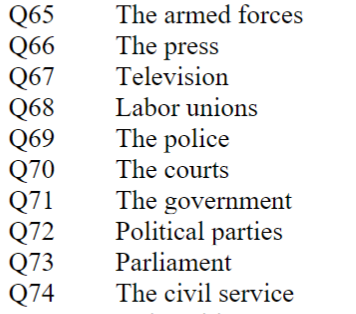

We will find the corresponding questions in this time series data to reconstruct the index. The encodings found are:
- E069_12 -> political parties
- E069_10 -> Television
- E069_04 -> the press
- E069_02 -> Armed Forces
- E069_05 -> Labor Unions
- E069_06 -> The Police
- E069_07 -> The Parliament
- E069_08 -> The Civil service
- E069_11 -> The government 
- E069_17 -> The Courts

In [4]:
# copying and slightly modifying the attach distrust index function from our utils 
def attach_national_distrust_index(df: pd.DataFrame) -> pd.DataFrame:
  national_trust_questions = ["E069_12", "E069_10", "E069_04", "E069_02", "E069_05", "E069_06", "E069_07", "E069_08", "E069_11", "E069_17"]

  result = df.copy()

  # 1. imputing with median --------------------------------------------
  # create a median dict with all the relevant values
  median_dict = {}
  countries = result.COUNTRY_ALPHA.unique()

  for ct in countries:
      median_dict[ct] = {}

  for tq in national_trust_questions:
      for ct in countries:
          median_dict[ct][tq] = result.loc[(result[tq] > 0) & (result.COUNTRY_ALPHA == ct), tq].median()
  
  # now populate the dataframe with the median values
  for tq in national_trust_questions:
      result[tq] = result.loc[:, [tq, "COUNTRY_ALPHA"]].apply(lambda row: median_dict[row["COUNTRY_ALPHA"]][tq] if row[tq] <= 0 else row[tq], axis=1)
    
  # 2. Minmax scaling --------------------------------------------
  scaler = MinMaxScaler()
  scaler.fit(result.loc[:, national_trust_questions])
  result.loc[:, national_trust_questions] = scaler.transform(result.loc[:, national_trust_questions])

  # 3. Creating trust indeces by rowwise mean --------------------------------------------
  result["national_distrust_index"] = result.loc[:, national_trust_questions].mean(axis=1)
  
  return result
  

In [5]:
df = attach_national_distrust_index(df)

## Rudimentary EDA
We are going to look at some line plots, histograms and boxplots to get a general feeling for the data

In [7]:
# renaming wave variable to wave
df.rename(columns={"S002VS": "wave"}, inplace=True)

<Axes: >

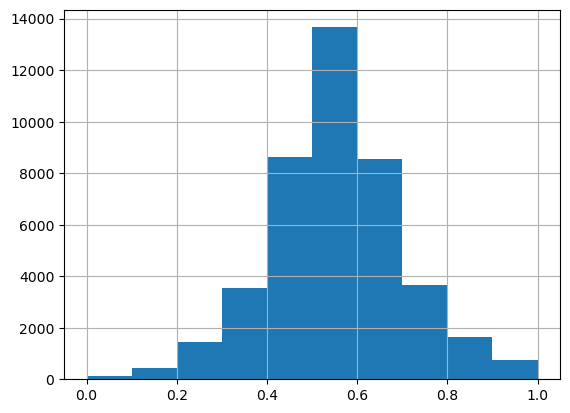

In [31]:
df.national_distrust_index.hist()

- index appears normal but of course is truncated for values beyond 0 and 1
- Model will not account for this and **might** cause problems

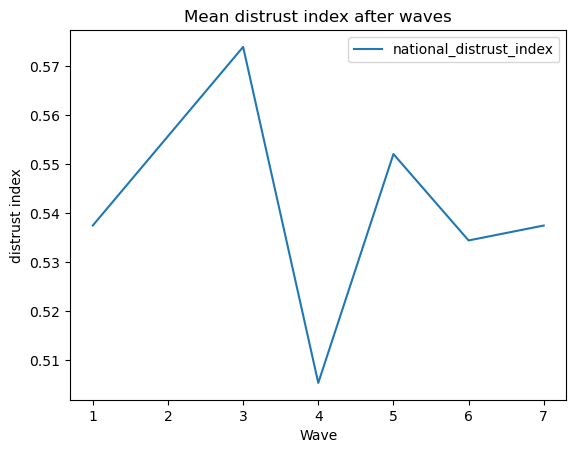

In [8]:
# How has distrust evolved over time in all countries
df.loc[:, ["wave", "national_distrust_index"]].groupby("wave").mean().plot()
plt.title("Mean distrust index after waves")
plt.xlabel("Wave")
plt.ylabel("distrust index")
plt.show()

- No trend when considering all countries

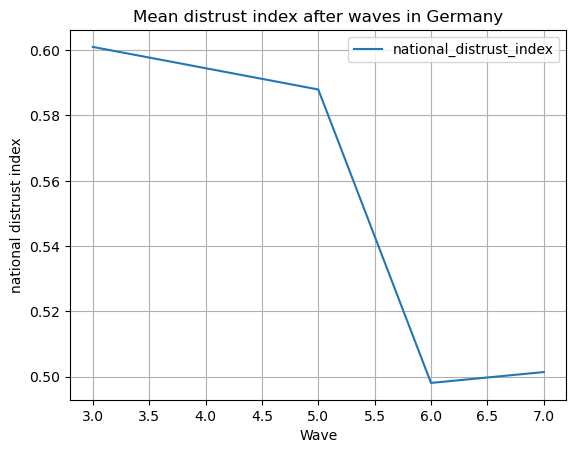

In [9]:
df.query("COUNTRY_ALPHA == 'DEU'")[["wave", "national_distrust_index"]].groupby("wave").mean().plot()
plt.title("Mean distrust index after waves in Germany")
plt.xlabel("Wave")
plt.ylabel("national distrust index")
plt.grid(True)

- Clear increase in trust during the last couple of waves

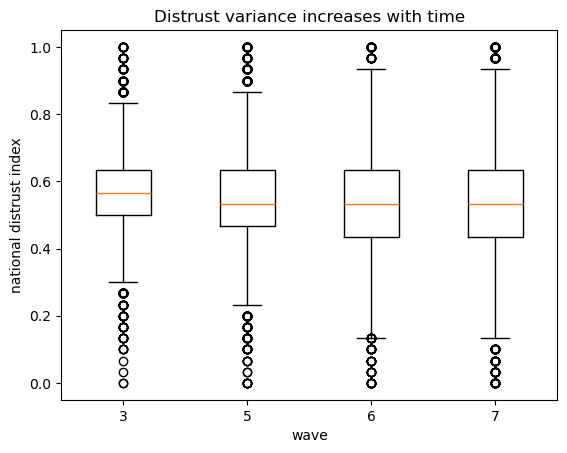

In [10]:
distrust_index_waves = []
for wave in [3,5,6,7]:
  distrust_index_waves.append(df.query("wave == @wave")["national_distrust_index"])

plt.boxplot(distrust_index_waves, tick_labels=["3","5","6","7"])
plt.title("Distrust variance increases with time")
plt.xlabel("wave")
plt.ylabel("national distrust index")
plt.show()

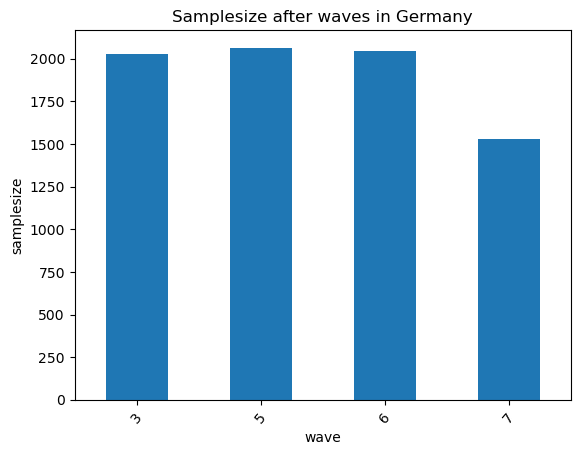

In [11]:
df.query("COUNTRY_ALPHA == 'DEU'").groupby("wave").size().plot(kind="bar")
plt.xticks(rotation=50)
plt.title("Samplesize after waves in Germany")
plt.xlabel("wave")
plt.ylabel("samplesize")
plt.show()

## Applying test stats
### Applying omnibus oneway ANOVA
- This just to check if our visual inspection is significant

In [25]:
print(f_oneway(*distrust_index_waves))

F_onewayResult(statistic=np.float64(115.85123336213962), pvalue=np.float64(1.1063858406726808e-74))


- Unsurprisingly we have differences in Germany

### Applying linear contrast oneway ANOVA
We have to be careful choosing the contrast coefficients here, because the wave variable is not equidistant. So we have waves `[3,5,6,7]`. This means, we have to find contrasts, that account for these distances and sum to zero:
$$
\sum_t c_t = 0 \hspace{1em} \land \hspace{1em} |c_1| > |c_4|
$$
An easy way to get these contrasts is to subtract the mean:
$$
\bar x = \frac 1C \sum_{t} w_t = \frac{3+5+6+7}{4} = 5.25
$$
The contrasts should be now:
$$
c_t = x_t -\bar x
$$
This yields the contrasts:
$$
\begin{align*}
c_1 &= 3-5.25 =  - 2.25\\
c_2 &= 5-5.25 = -0.25\\
c_3 &= 6-5.25 = 0.75\\
c_4 &= 7-5.25 = 1.75
\end{align*}
$$

Now we need to adjust these contrast coefficients to the linear regression. Which fits this model equation using robust OLS:
$$
ndt_i = \beta_0 + \sum_{i\in\{5,6,7\}} \beta_i x_i + \epsilon_i
$$
- $ndt_i$ the national distrust index for observation $i$
- $\beta_0$ the intercept (also including the variation in wave 3)
- $\beta_i$ the difference between wave 5,6,7 respectively and wave 3
- $x_i$ dummy variable for wave 5,6,7
- $\epsilon_i\sim \mathcal N (0, \sigma_i)$ heteroscedastic error term 

Since here the $\beta_i$ coefficients represent change with respect to wave 3, we get the means as:
$$
\begin{align*}
\mu_1 &= \beta_0\\
\mu_2 &= \beta_0 + \beta_1\\
\mu_3 &= \beta_0 +\beta_2\\
\mu_4 &= \beta_0 +\beta_3
\end{align*}
$$

Using this, we can formulate the $H_0$ hypothesis:
$$
H_0: \sum_{i=1}^4 c_i\mu_i = 0 \Longleftrightarrow H_0: c_1\beta_0 + \sum_{i=2}^4 c_i(\beta_0+\beta_{i-1}) = 0 \Longleftrightarrow H_0: \beta_0\sum_{i=1}^4c_i + \sum_{i=2}^4 c_i\beta_{i-1} = 0
$$
And since by construction it holds, that our contrasts sum up to 0, we get the final hypothesis (which we then test in the code):
$$
H_0: \sum_{i=2}^4c_i\beta_{i-1} = 0
$$

In [28]:
# Using white sandwich estimator for the coefficients to have a robust estimate against the changing variance 
model = ols("national_distrust_index ~ C(wave)", data = df.query("COUNTRY_ALPHA == 'DEU'")).fit(cov_type='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     national_distrust_index   R-squared:                       0.095
Model:                                 OLS   Adj. R-squared:                  0.095
Method:                      Least Squares   F-statistic:                     275.2
Date:                     Sat, 18 Jan 2025   Prob (F-statistic):          1.18e-169
Time:                             11:30:37   Log-Likelihood:                 3845.3
No. Observations:                     7664   AIC:                            -7683.
Df Residuals:                         7660   BIC:                            -7655.
Df Model:                                3                                         
Covariance Type:                       HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6010      0.003    204.265      0.000       0.595       0.607
C(wave)[T.5]    -0.0130      0.004     -2.917      0.004      -0.022      -0.004
C(wave)[T.6]    -0.1029      0.004    -22.912      0.000      -0.112      -0.094
C(wave)[T.7]    -0.0996      0.005    -20.909      0.000      -0.109      -0.090
==============================================================================
Omnibus:                       25.759   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.732
Skew:                           0.108   Prob(JB):                     9.51e-07
Kurtosis:                       3.201   Cond. No.                         4.70
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

- $R^2$ is quite good for a Case Studies linear regression

In [29]:
# wave 3 serves as reference class (so coefficient for beta_0 is = 0)
contrasts = [0, -0.25, 0.75, 1.75]
print(model.t_test(contrasts))

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.2482      0.010    -25.604      0.000      -0.267      -0.229


- Found evidence for a trend with contrast ANOVA